## Simple CNN Classifier Starter (Pytorch)
* Using EfficientNet-B0 as basebone
* Not do segmentation
* Only do classification task on gleason_score(then map to isup score****)

In [ ]:
import os
# There are two ways to load the data from the PANDA dataset:
# Option 1: Load images using openslide
import openslide
# Option 2: Load images using skimage (requires that tifffile is installed)
import skimage.io

from tqdm import tqdm_notebook as tqdm
import warnings
# General packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import PIL
from IPython.display import Image, display

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import model_zoo
from torch.utils.data import Dataset, DataLoader, RandomSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from torch.optim import Adam,SGD
import torchvision.models as models

# Plotly for the interactive viewer (see last section)
import plotly.graph_objs as go
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random_seed = 644

## Download EfficientNet
* For training, inference kernel can't turn on internet

In [ ]:
import sys
package_path = '../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master'
sys.path.append(package_path)
from efficientnet_pytorch import EfficientNet

In [ ]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    # random.seed(seed)
    # os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(random_seed)

## Load train data

In [ ]:
# Location of the training images
data_dir = '/kaggle/input/prostate-cancer-grade-assessment/train_images'
mask_dir = '/kaggle/input/prostate-cancer-grade-assessment/train_label_masks'

# Location of training labels
train_labels = pd.read_csv('/kaggle/input/prostate-cancer-grade-assessment/train.csv')

## Set map dictionary 

In [ ]:
label_map = {label : i for i, label in enumerate(train_labels['gleason_score'])}

for i,label_name in enumerate(label_map):
    label_map[label_name] =i
    
map_label = {label_map[index] : index for i, index in enumerate(label_map)}
isup_map = {"0+0":0,'negative':0,'3+3':1,'3+4':2,'4+3':3,'4+4':4,'3+5':4,'5+3':4,'4+5':5,'5+4':5,'5+5':5}

In [ ]:
train_labels['label'] = train_labels['gleason_score'].map(label_map)

## PANDA Dataset

In [ ]:
class prostate_data(Dataset):
    def __init__(self, anotation, img_dir, mode='train', size=(512,512), transform=None):
        self.anotation = anotation
        self.img_dir = img_dir
        self.size = size
        self.mode = mode
        self.transforms = transform
        
    def __len__(self):
        return len(self.anotation)
    
    def __getitem__(self, idx):
        
        if self.mode == 'test':
            img_id, provide  = self.anotation.loc[idx,['image_id','data_provider']].values
        else:
            img_id, label, provide  = self.anotation.loc[idx,['image_id','label','data_provider']].values
            
        img_path = os.path.join(self.img_dir, img_id+'.tiff')
        
        image = openslide.OpenSlide(img_path)
        image = np.array(image.get_thumbnail(size=self.size).resize(self.size))
        #print (image.shape)
        
        image = self.transforms(image=image)['image']
        #print (image.shape)
        #image =  np.rollaxis(image, 2, 0) / 255
        
        if self.mode == 'train' or self.mode == 'valid':
            return image, torch.tensor(label)
        else:
            return image

## Data augmentation

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
SIZE = 512
transforms_train = A.Compose([
    A.RandomResizedCrop(height=SIZE, width=SIZE, p=1.0),
    A.Flip(),
    A.ShiftScaleRotate(rotate_limit=1.0, p=0.8),

    # Pixels
    A.OneOf([
        A.IAAEmboss(p=1.0),
        A.IAASharpen(p=1.0),
        A.Blur(p=1.0),
    ], p=0.5),

    # Affine
    A.OneOf([
        A.ElasticTransform(p=1.0),
        A.IAAPiecewiseAffine(p=1.0)
    ], p=0.5),

    A.Normalize(p=1.0),
    ToTensorV2(p=1.0),
])

transforms_valid = A.Compose([
    A.Resize(height=SIZE, width=SIZE, p=1.0),
    A.Normalize(p=1.0),
    ToTensorV2(p=1.0),
])

## Split tran and valid set
* only using 1000 data as training set to reduce kernel run-time

In [ ]:
train, valid = train_test_split(train_labels,test_size=0.2,stratify= train_labels['label'])

In [ ]:
train_dataset = prostate_data(train[:1000].reset_index(drop=True),data_dir, transform=transforms_train)
valid_dataset = prostate_data(valid[:200].reset_index(drop=True),data_dir, transform=transforms_valid)

In [ ]:
batch_size=16
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
x_train, y = next(iter(valid_loader))

## Display Image

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
def display_imgs(x):
    cmaps = ['gist_ncar','terrain', 'gnuplot' ,'rainbow','PiYG', 'gist_earth']
    columns = 2
    bs = x.shape[0]
    rows =2
    fig=plt.figure(figsize=(columns*4, rows*4))
    for i in range(rows):
        for j in range(columns):
            idx = i+j*columns
            fig.add_subplot(rows, columns, idx+1)
            plt.axis('off')
           # x = np.swapaxes(x,1,-1)
            plt.imshow((np.swapaxes(x,1,-1)[idx,:,:,:]*255).astype(np.int))
    plt.show()
    
display_imgs(np.array(x_train))

## Load model

In [ ]:
model_ft = EfficientNet.from_name('efficientnet-b0')
model_ft.load_state_dict(torch.load('../input/efficientnet-pytorch/efficientnet-b0-08094119.pth'))
in_features = model_ft._fc.in_features
model_ft._fc = nn.Linear(in_features,len(label_map))
#model_ft = EfficientNet.from_pretrained('efficientnet-b0', num_classes=len(label_map))
model_ft = model_ft.to(device)

In [ ]:
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report,auc,roc_curve,cohen_kappa_score

## Start training

In [ ]:
lr = 0.0005
eta_min = 1e-5
t_max = 10
criterion = nn.CrossEntropyLoss()
optimizer = Adam(params=model_ft.parameters(), lr=lr)

tlen = len(train_loader)
tlen_valid = len(valid_loader)
accumulation_steps = 2
valid_pred = np.zeros((len(valid[:200]),11))
train_pred = np.zeros((len(train[:1000]),11))
train_target = np.zeros((len(train[:1000])))

for epoch in range(5):
    batch_i = 0
    tloss = 0
    tloss_valid = 0
    acc = np.zeros(1)
    acc_valid = np.zeros(1)
    
    model_ft.train()
    optimizer.zero_grad()
    for i,(x_train, y_train) in enumerate(tqdm(train_loader)): 
        outputs = model_ft(x_train.cuda())
        
        loss = criterion(outputs,  y_train.long().cuda())
        loss.backward()
        if (batch_i+1) % accumulation_steps == 0:            
            optimizer.step()                           
            optimizer.zero_grad()
        
        tloss += loss.item()
        batch_i+=1
        
        train_pred[i * batch_size:(i+1) * batch_size] = outputs.detach().cpu().numpy()
        train_target[i * batch_size:(i+1) * batch_size] = y_train.detach().cpu().numpy()

        del loss, outputs, y_train, x_train

    #Valid acc
    model_ft.eval()
    for i,(x_train, y_train) in enumerate(valid_loader):
        outputs = model_ft(x_train.cuda())
        loss = criterion(outputs,  y_train.long().cuda())
        tloss_valid += loss.item()
        valid_pred[i * batch_size:(i+1) * batch_size] = outputs.detach().cpu().numpy()
        del loss, outputs, y_train, x_train
        
    acc = cohen_kappa_score(train_pred.argmax(axis =1),train_target,weights='quadratic')
    acc_valid = cohen_kappa_score(valid_pred.argmax(axis =1),valid['label'][:200],weights='quadratic')
    
    print('Epoch {} -> Train Loss: {:.4f}, Valid Loss: {:.4f}, ACC_train: {:.2f}%, ACC_valid: {:.2f}%'.format(epoch+1, tloss/tlen, tloss_valid/tlen_valid, acc, acc_valid))

## Plot confusion matrix

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
cmatrix = confusion_matrix(valid_pred.argmax(axis =1),valid['label'][:200])

In [ ]:
plot_confusion_matrix(cm           = cmatrix, 
                      normalize    = False,
                      target_names = list(label_map.keys()),
                      title        = "Confusion Matrix")

## Inference
* If you submit your answer, you will find test_image folder

In [ ]:
test_labels = pd.read_csv('/kaggle/input/prostate-cancer-grade-assessment/test.csv')
test_dir = '/kaggle/input/prostate-cancer-grade-assessment/test_images'

if os.path.exists(test_dir):
    test_dataset = prostate_data(test_labels,test_dir,mode='test',transform=transforms_valid)
    test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size, shuffle=False)
    test_pred = np.zeros((len(test_labels),11))
    model_ft.eval()
    for i,(x_train) in enumerate(tqdm(test_loader)):
        outputs = model_ft(x_train.cuda())
        test_pred[i * batch_size:(i+1) * batch_size] = outputs.detach().cpu().numpy()
        del outputs,x_train

In [ ]:
sub = pd.read_csv('/kaggle/input/prostate-cancer-grade-assessment/sample_submission.csv')
test_dir = '/kaggle/input/prostate-cancer-grade-assessment/test_images'
if os.path.exists(test_dir):
    sub['isup_grade'] = test_pred.argmax(axis=1)
    sub['isup_grade'] = sub['isup_grade'].map(map_label)
    sub['isup_grade'] = sub['isup_grade'].map(isup_map)
sub.to_csv('submission.csv',index=False)

In [ ]:
test_labels

## Next Step
* try segmentation on this competition (Should be)
* This is the simple classifier on this task, but I think this is not the best way to solve this task
* https://ai.googleblog.com/2018/11/improved-grading-of-prostate-cancer.html
* 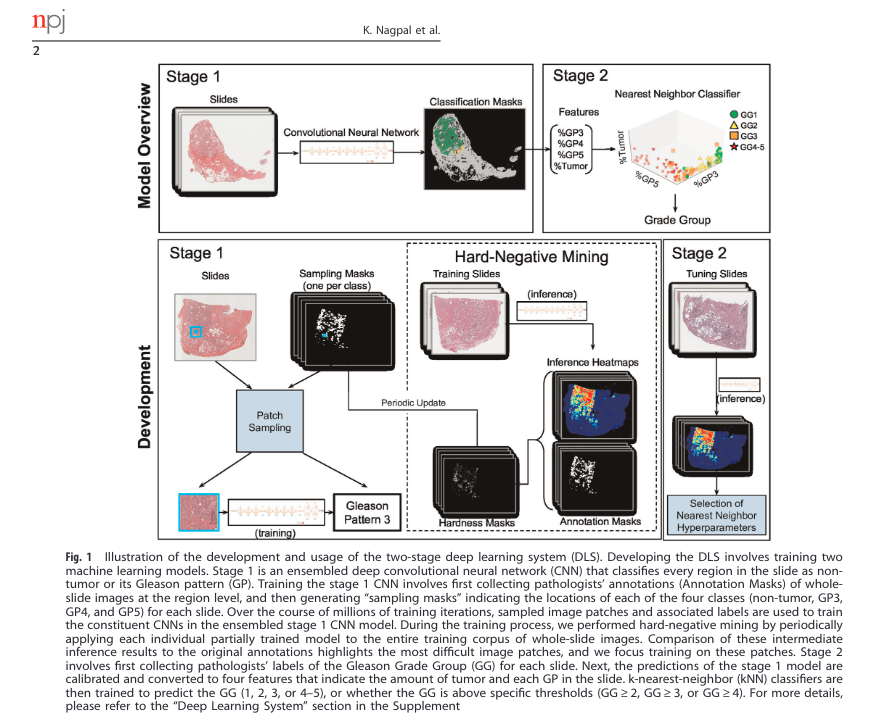